In [1]:
import torch
import torch.nn.functional as F
import triton
import triton.language as tl
from triton.runtime import driver
from pprint import pprint

In [2]:
DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}')

In [3]:
properties = driver.active.utils.get_device_properties(DEVICE.index)
pprint(f"{properties=}", underscore_numbers=True)
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
target = triton.runtime.driver.active.get_current_target()
kernels = {}

("properties={'max_shared_mem': 101376, 'max_num_regs': 65536, "
 "'multiprocessor_count': 84, 'warpSize': 32, 'sm_clock_rate': 1740000, "
 "'mem_clock_rate': 7251000, 'mem_bus_width': 384}")


In [4]:
@triton.jit
def rms_norm_kernel_2(input_ptr: torch.Tensor, output_ptr: torch.Tensor, input_row_stride: int,
             gamma: torch.Tensor, num_rows: int, num_cols: int, 
             eps: float, BLOCK_SIZE: tl.constexpr, num_stages: tl.constexpr):  
    row_idx = tl.program_id(0)
    row_start_ptr = input_ptr + row_idx * input_row_stride
    output_start_ptr = output_ptr + row_idx * input_row_stride
    col_offsets = tl.arange(0, BLOCK_SIZE)
    squared_x = 0.0
    for k in tl.range(0, tl.cdiv(num_cols, BLOCK_SIZE), num_stages=num_stages):
        offs_col = col_offsets + k * BLOCK_SIZE
        input_ptrs = row_start_ptr + offs_col
        mask = offs_col < num_cols
        x = tl.load(input_ptrs, mask=mask, other=0.0)
        squared_x += tl.sum(x * x)
    squared_x /= num_cols
    inv_sqrt = tl.rsqrt(eps + squared_x)
    
    for k in tl.range(0, tl.cdiv(num_cols, BLOCK_SIZE), num_stages=num_stages):
        offs_col = col_offsets + k * BLOCK_SIZE
        input_ptrs = row_start_ptr + offs_col
        mask = offs_col < num_cols
        inputs = tl.load(input_ptrs, mask=mask, other=0.0)
        gammas = tl.load(gamma + offs_col, mask=mask, other=1.0)
        out = inputs * inv_sqrt * gammas
        out_ptrs = output_start_ptr + offs_col
        tl.store(out_ptrs, out, mask=mask)
        
        


In [5]:
@triton.jit
def rms_norm_kernel(input_ptr: torch.Tensor, output_ptr: torch.Tensor, input_row_stride: int,
             gamma: torch.Tensor, num_rows: int, num_cols: int, 
             eps: float, BLOCK_SIZE: tl.constexpr, num_stages: tl.constexpr):  
    row_idx = tl.program_id(0)
    row_start_ptr = input_ptr + row_idx * input_row_stride
    output_start_ptr = output_ptr + row_idx * input_row_stride
    col_offsets = tl.arange(0, BLOCK_SIZE)
    
    gamma_block_ptr = tl.make_block_ptr(
        gamma,
        shape=(num_cols,),
        strides=(1,),
        offsets=(0,),
        block_shape=(BLOCK_SIZE,),
        order=(0,)
    )
    
    squared_x = 0.0
    for k in tl.range(0, tl.cdiv(num_cols, BLOCK_SIZE), num_stages=num_stages):
        offs_col = col_offsets + k * BLOCK_SIZE
        input_ptrs = row_start_ptr + offs_col
        mask = offs_col < num_cols
        x = tl.load(input_ptrs, mask=mask, other=0.0)
        squared_x += tl.sum(x * x)
    squared_x /= num_cols
    inv_sqrt = tl.rsqrt(eps + squared_x)
    
    for k in tl.range(0, tl.cdiv(num_cols, BLOCK_SIZE), num_stages=num_stages):
        offs_col = col_offsets + k * BLOCK_SIZE
        input_ptrs = row_start_ptr + offs_col
        mask = offs_col < num_cols
        inputs = tl.load(input_ptrs, mask=mask, other=0.0)
        current_gamma_ptr = tl.advance(gamma_block_ptr, (k * BLOCK_SIZE))
        gammas = tl.load(current_gamma_ptr)
        out = inputs * inv_sqrt * gammas
        out_ptrs = output_start_ptr + offs_col
        tl.store(out_ptrs, out, mask=mask)

In [6]:
def rms_norm(a: torch.Tensor, gamma: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    b = torch.zeros_like(a)
    M, N = a.shape
    num_stages = 8
    BLOCK_SIZE = 1024
    grid= (M,)
    rms_norm_kernel[grid](a, b, a.stride(0), gamma, M, N, eps, BLOCK_SIZE=BLOCK_SIZE, num_stages=num_stages)
    return b

In [9]:
torch.manual_seed(0)
a = torch.randn((64, 512), device=DEVICE, dtype=torch.float32)
N, D = a.shape
gamma = torch.randn(512, device=DEVICE, dtype=torch.float32)
beta = torch.randn(512, device=DEVICE, dtype=torch.float32)
triton_output = rms_norm(a, gamma, eps=1e-5)
torch_output = F.rms_norm(a, normalized_shape=(D,), weight=gamma, eps=1e-5)
if torch.allclose(triton_output, torch_output, atol=0.125, rtol=0):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")

✅ Triton and Torch match


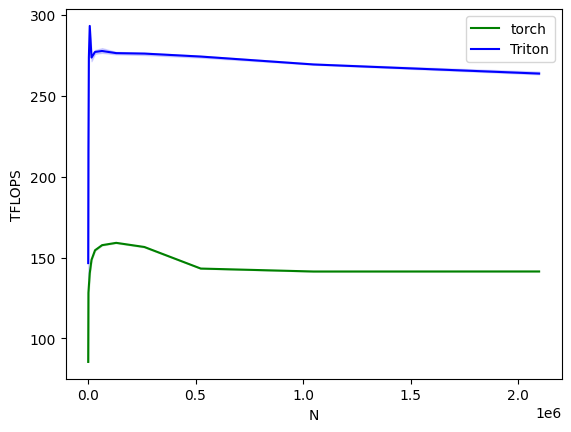

matmul-performance-fp32:
            N       torch      Triton
0      1024.0   85.499997  146.571427
1      2048.0  128.250000  216.000010
2      4096.0  132.387099  273.600007
3      8192.0  140.307688  293.142853
4     16384.0  148.561089  273.600007
5     32768.0  154.503527  277.063291
6     65536.0  157.656663  277.649053
7    131072.0  159.089037  276.334555
8    262144.0  156.529204  276.044133
9    524288.0  143.195307  274.206955
10  1048576.0  141.379175  269.321719
11  2097152.0  141.407716  263.694288
None


In [11]:
configs = []
ref_lib = "torch"
batch_sizes = [256]
for M in batch_sizes:
    configs.append(
        triton.testing.Benchmark(
            x_names=["N"],  # Argument names to use as an x-axis for the plot
            x_vals=[2**i for i in range(10, 22)],  # Different possible values for `x_name`
            line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
            # Possible values for `line_arg`
            # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
            line_vals=[ref_lib.lower(), "triton"] , # Label name for the lines
            line_names=[ref_lib, "Triton"],  # Line styles
            styles=[("green", "-"), ("blue", "-")],
            ylabel="TFLOPS",  # Label name for the y-axis
            plot_name="matmul-performance-" +
            ("fp32"),  # Name for the plot, used also as a file name for saving the plot.
            args={"M": M},
        ))
@triton.testing.perf_report(configs)
def benchmark(N, provider, M):
    a = torch.randn((M, N), device=DEVICE, dtype=torch.float32)
    gamma = torch.randn(N, device=DEVICE, dtype=torch.float32)
    beta = torch.randn(N, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == ref_lib.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: F.rms_norm(a, normalized_shape=(N,), weight=gamma, eps=1e-5), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: rms_norm(a, gamma, eps=1e-5), quantiles=quantiles)
    # Calculate memory bandwidth: bytes_accessed / runtime_in_seconds
    # For LayerNorm, we read the input tensor once, read gamma and beta, and write to output
    # Each float32 element is 4 bytes
    bytes_accessed = M * N * 4 * 2 + N * 4  # Input + Output + gamma
    gb_per_s = lambda ms: bytes_accessed * 1e-9 / (ms * 1e-3)
    
    return gb_per_s(ms), gb_per_s(max_ms), gb_per_s(min_ms)


print(benchmark.run(show_plots=True, print_data=True))